In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:

from tensorflow.keras.datasets.mnist import load_data
(x_train,y_train), (x_test,y_test) = load_data()

11490434/11490434 [==============================] - 0s 0us/step


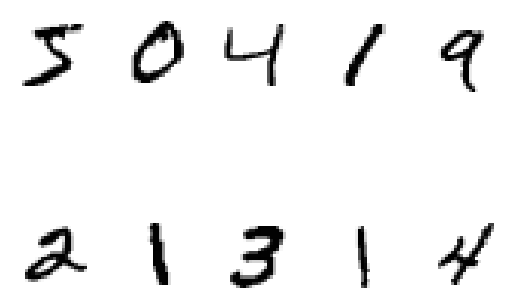

In [3]:
#plotting first 10 images
import matplotlib.pyplot as pyplot
for i in range(10):
  pyplot.subplot(2, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(x_train[i], cmap='gray_r')
pyplot.show()

In [4]:
print(x_test.shape)

(10000, 28, 28)


In [5]:
X_train = x_train.astype('float32')
X_train = (X_train - 127.5)/127.5

X_test = x_test.astype('float32')
X_test = (X_test - 127.5)/127.5



In [6]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [7]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

In [8]:

#functional API for discriminator model
def discriminator(in_shape=(28,28,1),n_classes=10):
    #label input
    # each label is represented by a vector of size 50
    in_label=Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)
    n_nodes = in_shape[0] * in_shape[1]  #28x28
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)  #adding additional channel - 28x28x1

    #image input
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li]) #28x28x2

    #downsampling to 7x7x1
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #14x14x128
    fe= LeakyReLU(alpha=0.2)(fe)
    fe= Conv2D(128,(3,3), strides=(2,2), padding='same')(fe) #7x7x128
    fe= LeakyReLU(alpha=0.2)(fe)
    fe= Flatten()(fe)
    fe= Dropout(0.4)(fe)
    output= Dense(1, activation='sigmoid')(fe) #probability whether the image is real or fake

    #model
    model = Model([in_image, in_label], output)
    opt=Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer= opt,metrics=['accuracy'])
    return model

In [9]:
discriminator=discriminator()
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 50)                500       ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 1, 784)               39984     ['embedding[0][0]']           
                                                                                                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                              

In [10]:
#functional API for generator model
def generator(latent_dim,n_classes=10):

    #label input
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 50)(in_label)

    n_nodes = 7 * 7 # to match the dimensions for concatenation later
    li = Dense(n_nodes)(li) #1,49
    li = Reshape((7, 7, 1))(li)

    #image generator input
    in_lat = Input(shape=(latent_dim,)) #100
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)

    #merge image and label
    merge = Concatenate()([gen, li]) #7x7x128

    #upsampling to (28,28,1)
    gen = Conv2DTranspose(128, (2,2), strides=(1,1), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    output=Conv2D(1,(7,7),activation='tanh', padding='same')(gen)
    model=Model([in_lat, in_label], output) #model that takes noise and label as input and generates output_layer
    return model


In [11]:
latent_dim=100
generator = generator(latent_dim)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 6272)                 633472    ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_3[0][0]']             
                                                                                            

In [12]:
def cgan(d_model, g_model, latent_dim, n_classes=10):
    d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
    gen_output = g_model.output  #28x28x1

	# generator image output and corresponding input label are inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)


    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

In [13]:
cgan=cgan(discriminator, generator, latent_dim)
cgan.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_3 (Dense)             (None, 6272)                 633472    ['input_4[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 50)                500       ['input_3[0][0]']             
                                                                                            

In [14]:
def load_real_samples():
    #load dataset as list of 2 arrays
    return [X_train, y_train]

In [15]:
def generate_real_samples(dataset, samples):
    #returning a batch of real inputs and outputs to train the GAN
    images, labels = dataset
    ix = np.random.randint(0, images.shape[0], samples)
    X, labels = images[ix], labels[ix]

    y = np.ones((samples, 1))
    return [X, labels], y


In [16]:

def generate_latent_points(latent_dim, n_samples,n_classes=10):
    #for generator input
    X_input = np.random.randn(latent_dim * n_samples)
    Z_input = X_input.reshape(n_samples, latent_dim)

    labels = np.random.randint(0, n_classes, n_samples)
    return [Z_input, labels]

In [17]:
def generate_fake_samples(generator, latent_dim, samples):
    #returning fake inputs and outputs
    Z_input, labels_input = generate_latent_points(latent_dim, samples)

    images = generator.predict([Z_input, labels_input])

    y = np.zeros((samples, 1))
    return [images, labels_input], y

In [18]:
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, epochs=100, batch_size=128):
    batch_per_epo = int(dataset[0].shape[0]/batch_size) #total/batchsize
    half_batch = int(batch_size/2)
    for i in range(epochs):
        for j in range(batch_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
            #get randomly selceted 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            discriminator_loss1, _ = discriminator_model.train_on_batch([X_real, labels_real], y_real)
            #generate fake samples
            [X_fake, labels], y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)
            discriminator_loss2, _ = discriminator_model.train_on_batch([X_fake, labels], y_fake)

            #latent points for input to generator
            [z_input, labels_input] = generate_latent_points(latent_dim, batch_size)

            #inverted labels for fake samples
            y_gan = np.ones((batch_size, 1))

            generator_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            print(f'Epoch: {i+1}, Batch: {j+1}/{batch_per_epo}, disc_loss_r = {discriminator_loss1}, disc_loss_f = {discriminator_loss2}, generator loss = {generator_loss}')
        generator_model.save('mnist_cGAN.h5')

In [19]:
dataset = load_real_samples()
train(generator, discriminator,cgan, dataset, latent_dim, epochs=20)


2/2 [==============================] - 1s 7ms/step
Epoch: 1, Batch: 1/468, disc_loss_r = 0.6722462177276611, disc_loss_f = 0.6954870223999023, generator loss = 0.691597580909729
2/2 [==============================] - 0s 8ms/step
Epoch: 1, Batch: 2/468, disc_loss_r = 0.5783261060714722, disc_loss_f = 0.6992251873016357, generator loss = 0.6873168349266052
2/2 [==============================] - 0s 6ms/step
Epoch: 1, Batch: 3/468, disc_loss_r = 0.5094452500343323, disc_loss_f = 0.7075527906417847, generator loss = 0.678913414478302
2/2 [==============================] - 0s 5ms/step
Epoch: 1, Batch: 4/468, disc_loss_r = 0.4466334879398346, disc_loss_f = 0.7228995561599731, generator loss = 0.6641451716423035
2/2 [==============================] - 0s 6ms/step
Epoch: 1, Batch: 5/468, disc_loss_r = 0.3908306360244751, disc_loss_f = 0.7498793601989746, generator loss = 0.6411844491958618
2/2 [==============================] - 0s 5ms/step
Epoch: 1, Batch: 6/468, disc_loss_r = 0.3403393626213074

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 1, Batch: 468/468, disc_loss_r = 8.734830771572888e-06, disc_loss_f = 0.0005216676509007812, generator loss = 8.0291748046875
2/2 [==============================] - 0s 6ms/step
Epoch: 2, Batch: 1/468, disc_loss_r = 0.0001310601073782891, disc_loss_f = 0.0004404656065162271, generator loss = 7.975494861602783
2/2 [==============================] - 0s 6ms/step
Epoch: 2, Batch: 2/468, disc_loss_r = 4.415973648974614e-07, disc_loss_f = 0.00037167061236687005, generator loss = 8.113153457641602
2/2 [==============================] - 0s 6ms/step
Epoch: 2, Batch: 3/468, disc_loss_r = 5.0673213991103694e-05, disc_loss_f = 0.00045144755858927965, generator loss = 8.237996101379395
2/2 [==============================] - 0s 6ms/step
Epoch: 2, Batch: 4/468, disc_loss_r = 1.6349476936738938e-06, disc_loss_f = 0.0004021571367047727, generator loss = 8.36609935760498
2/2 [==============================] - 0s 6ms/step
Epoch: 2, Batch: 5/468, disc_loss_r = 0.0001389863609801978, disc_loss_f = 0.

Epoch: 2, Batch: 468/468, disc_loss_r = 0.00010699253471102566, disc_loss_f = 7.949641440063715e-05, generator loss = 9.730781555175781
2/2 [==============================] - 0s 5ms/step
Epoch: 3, Batch: 1/468, disc_loss_r = 2.2275548872130457e-07, disc_loss_f = 9.402634168509394e-05, generator loss = 9.873016357421875
2/2 [==============================] - 0s 6ms/step
Epoch: 3, Batch: 2/468, disc_loss_r = 1.0760885743366089e-05, disc_loss_f = 8.023947157198563e-05, generator loss = 9.794513702392578
2/2 [==============================] - 0s 6ms/step
Epoch: 3, Batch: 3/468, disc_loss_r = 0.0006106304354034364, disc_loss_f = 9.370859334012493e-05, generator loss = 9.667442321777344
2/2 [==============================] - 0s 7ms/step
Epoch: 3, Batch: 4/468, disc_loss_r = 1.065664321231452e-07, disc_loss_f = 0.00011783133959397674, generator loss = 9.696130752563477
2/2 [==============================] - 0s 6ms/step
Epoch: 3, Batch: 5/468, disc_loss_r = 3.9187657421280164e-06, disc_loss_f 

Epoch: 3, Batch: 468/468, disc_loss_r = 0.0002895854413509369, disc_loss_f = 2.34232320508454e-05, generator loss = 11.061203956604004
2/2 [==============================] - 0s 6ms/step
Epoch: 4, Batch: 1/468, disc_loss_r = 1.4487607131741242e-06, disc_loss_f = 2.2665661163046025e-05, generator loss = 11.0945463180542
2/2 [==============================] - 0s 7ms/step
Epoch: 4, Batch: 2/468, disc_loss_r = 1.3151870916772168e-06, disc_loss_f = 2.2833066395833157e-05, generator loss = 11.186421394348145
2/2 [==============================] - 0s 6ms/step
Epoch: 4, Batch: 3/468, disc_loss_r = 1.8089402828991297e-06, disc_loss_f = 2.3381511709885672e-05, generator loss = 11.126975059509277
2/2 [==============================] - 0s 7ms/step
Epoch: 4, Batch: 4/468, disc_loss_r = 6.1659175116801634e-06, disc_loss_f = 2.8856615244876593e-05, generator loss = 11.04340648651123
2/2 [==============================] - 0s 5ms/step
Epoch: 4, Batch: 5/468, disc_loss_r = 1.9263080019982226e-08, disc_lo

Epoch: 4, Batch: 468/468, disc_loss_r = 2.174281661382338e-07, disc_loss_f = 1.015895395539701e-05, generator loss = 11.969621658325195
2/2 [==============================] - 0s 6ms/step
Epoch: 5, Batch: 1/468, disc_loss_r = 0.00020146222959738225, disc_loss_f = 8.494338544551283e-06, generator loss = 11.747589111328125
2/2 [==============================] - 0s 10ms/step
Epoch: 5, Batch: 2/468, disc_loss_r = 6.632449185417499e-07, disc_loss_f = 1.105402952816803e-05, generator loss = 11.860158920288086
2/2 [==============================] - 0s 6ms/step
Epoch: 5, Batch: 3/468, disc_loss_r = 1.10512551998454e-07, disc_loss_f = 9.593644790584221e-06, generator loss = 11.889396667480469
2/2 [==============================] - 0s 6ms/step
Epoch: 5, Batch: 4/468, disc_loss_r = 7.2879484669385874e-09, disc_loss_f = 1.0458100405230653e-05, generator loss = 11.781988143920898
2/2 [==============================] - 0s 6ms/step
Epoch: 5, Batch: 5/468, disc_loss_r = 4.4910436258760456e-08, disc_los

Epoch: 5, Batch: 468/468, disc_loss_r = 1.3294271239416844e-09, disc_loss_f = 4.705174887931207e-06, generator loss = 12.353073120117188
2/2 [==============================] - 0s 6ms/step
Epoch: 6, Batch: 1/468, disc_loss_r = 4.961012045612279e-09, disc_loss_f = 5.128294560563518e-06, generator loss = 12.541921615600586
2/2 [==============================] - 0s 6ms/step
Epoch: 6, Batch: 2/468, disc_loss_r = 6.746218028652606e-10, disc_loss_f = 5.08338871441083e-06, generator loss = 12.49691390991211
2/2 [==============================] - 0s 6ms/step
Epoch: 6, Batch: 3/468, disc_loss_r = 9.435186854034328e-09, disc_loss_f = 3.724359203260974e-06, generator loss = 12.598097801208496
2/2 [==============================] - 0s 5ms/step
Epoch: 6, Batch: 4/468, disc_loss_r = 0.0001302300806855783, disc_loss_f = 5.632541615341324e-06, generator loss = 12.444089889526367
2/2 [==============================] - 0s 6ms/step
Epoch: 6, Batch: 5/468, disc_loss_r = 7.053746685414808e-06, disc_loss_f =

Epoch: 6, Batch: 468/468, disc_loss_r = 1.2040153762882255e-07, disc_loss_f = 9.662433512858115e-06, generator loss = 12.002045631408691
2/2 [==============================] - 0s 9ms/step
Epoch: 7, Batch: 1/468, disc_loss_r = 3.2246860737217276e-09, disc_loss_f = 8.064957000897266e-06, generator loss = 12.050999641418457
2/2 [==============================] - 0s 5ms/step
Epoch: 7, Batch: 2/468, disc_loss_r = 1.2662332293800205e-10, disc_loss_f = 1.1336231182212941e-05, generator loss = 11.927939414978027
2/2 [==============================] - 0s 6ms/step
Epoch: 7, Batch: 3/468, disc_loss_r = 1.2685267766765485e-11, disc_loss_f = 1.1007984539901372e-05, generator loss = 12.123709678649902
2/2 [==============================] - 0s 6ms/step
Epoch: 7, Batch: 4/468, disc_loss_r = 6.941914057478904e-12, disc_loss_f = 8.737552889215294e-06, generator loss = 12.251777648925781
2/2 [==============================] - 0s 6ms/step
Epoch: 7, Batch: 5/468, disc_loss_r = 1.1466449123531675e-08, disc_

Epoch: 7, Batch: 468/468, disc_loss_r = 5.8598811136789664e-08, disc_loss_f = 1.319439093094843e-06, generator loss = 13.791091918945312
2/2 [==============================] - 0s 8ms/step
Epoch: 8, Batch: 1/468, disc_loss_r = 1.680637851109168e-10, disc_loss_f = 1.3621885273096268e-06, generator loss = 14.010743141174316
2/2 [==============================] - 0s 7ms/step
Epoch: 8, Batch: 2/468, disc_loss_r = 6.948107644788593e-10, disc_loss_f = 1.7124684745795093e-06, generator loss = 14.091588020324707
2/2 [==============================] - 0s 6ms/step
Epoch: 8, Batch: 3/468, disc_loss_r = 5.763408639225531e-10, disc_loss_f = 1.4647258694822085e-06, generator loss = 14.033682823181152
2/2 [==============================] - 0s 8ms/step
Epoch: 8, Batch: 4/468, disc_loss_r = 1.0343170764315346e-09, disc_loss_f = 1.8777066088659922e-06, generator loss = 14.029682159423828
2/2 [==============================] - 0s 6ms/step
Epoch: 8, Batch: 5/468, disc_loss_r = 1.9460811628846386e-08, disc_

Epoch: 8, Batch: 468/468, disc_loss_r = 2.189858378187637e-06, disc_loss_f = 0.0008029051241464913, generator loss = 7.416172027587891
2/2 [==============================] - 0s 7ms/step
Epoch: 9, Batch: 1/468, disc_loss_r = 1.4083560927247163e-05, disc_loss_f = 0.0010215978836640716, generator loss = 7.417210102081299
2/2 [==============================] - 0s 6ms/step
Epoch: 9, Batch: 2/468, disc_loss_r = 0.01820388436317444, disc_loss_f = 0.0012633687583729625, generator loss = 6.785938262939453
2/2 [==============================] - 0s 6ms/step
Epoch: 9, Batch: 3/468, disc_loss_r = 4.47736238129437e-06, disc_loss_f = 0.002077005337923765, generator loss = 6.655083656311035
2/2 [==============================] - 0s 6ms/step
Epoch: 9, Batch: 4/468, disc_loss_r = 0.0013692706124857068, disc_loss_f = 0.00249398872256279, generator loss = 6.7271318435668945
2/2 [==============================] - 0s 5ms/step
Epoch: 9, Batch: 5/468, disc_loss_r = 0.00416434183716774, disc_loss_f = 0.0662605

Epoch: 9, Batch: 468/468, disc_loss_r = 0.7120531797409058, disc_loss_f = 0.8132079243659973, generator loss = 0.7492272853851318
2/2 [==============================] - 0s 7ms/step
Epoch: 10, Batch: 1/468, disc_loss_r = 0.691423773765564, disc_loss_f = 0.8281846642494202, generator loss = 0.7823647260665894
2/2 [==============================] - 0s 7ms/step
Epoch: 10, Batch: 2/468, disc_loss_r = 0.7021209001541138, disc_loss_f = 0.8541309833526611, generator loss = 0.7933885455131531
2/2 [==============================] - 0s 7ms/step
Epoch: 10, Batch: 3/468, disc_loss_r = 0.80083167552948, disc_loss_f = 0.8059881925582886, generator loss = 0.7835317850112915
2/2 [==============================] - 0s 7ms/step
Epoch: 10, Batch: 4/468, disc_loss_r = 0.7647072076797485, disc_loss_f = 0.7991236448287964, generator loss = 0.7532780766487122
2/2 [==============================] - 0s 7ms/step
Epoch: 10, Batch: 5/468, disc_loss_r = 0.806287944316864, disc_loss_f = 0.7447934746742249, generator 

Epoch: 10, Batch: 468/468, disc_loss_r = 0.6746174693107605, disc_loss_f = 0.721418023109436, generator loss = 0.8187891244888306
2/2 [==============================] - 0s 9ms/step
Epoch: 11, Batch: 1/468, disc_loss_r = 0.7218955159187317, disc_loss_f = 0.6990846991539001, generator loss = 0.7862358093261719
2/2 [==============================] - 0s 8ms/step
Epoch: 11, Batch: 2/468, disc_loss_r = 0.6555442214012146, disc_loss_f = 0.7065706253051758, generator loss = 0.8321139812469482
2/2 [==============================] - 0s 8ms/step
Epoch: 11, Batch: 3/468, disc_loss_r = 0.7188857793807983, disc_loss_f = 0.6995698809623718, generator loss = 0.800842821598053
2/2 [==============================] - 0s 11ms/step
Epoch: 11, Batch: 4/468, disc_loss_r = 0.7446795701980591, disc_loss_f = 0.6749374270439148, generator loss = 0.7896087169647217
2/2 [==============================] - 0s 6ms/step
Epoch: 11, Batch: 5/468, disc_loss_r = 0.7245265245437622, disc_loss_f = 0.6823736429214478, genera

Epoch: 11, Batch: 468/468, disc_loss_r = 0.547807514667511, disc_loss_f = 0.5654290914535522, generator loss = 1.0216931104660034
2/2 [==============================] - 0s 6ms/step
Epoch: 12, Batch: 1/468, disc_loss_r = 0.6204472780227661, disc_loss_f = 0.5627962350845337, generator loss = 1.0318090915679932
2/2 [==============================] - 0s 8ms/step
Epoch: 12, Batch: 2/468, disc_loss_r = 0.5972897410392761, disc_loss_f = 0.5114308595657349, generator loss = 1.143306016921997
2/2 [==============================] - 0s 6ms/step
Epoch: 12, Batch: 3/468, disc_loss_r = 0.5824148654937744, disc_loss_f = 0.45961636304855347, generator loss = 1.243354320526123
2/2 [==============================] - 0s 6ms/step
Epoch: 12, Batch: 4/468, disc_loss_r = 0.5474227666854858, disc_loss_f = 0.4793819189071655, generator loss = 1.2494432926177979
2/2 [==============================] - 0s 7ms/step
Epoch: 12, Batch: 5/468, disc_loss_r = 0.5521969795227051, disc_loss_f = 0.49212682247161865, genera

Epoch: 12, Batch: 468/468, disc_loss_r = 0.6365129947662354, disc_loss_f = 0.724481463432312, generator loss = 0.8139244318008423
2/2 [==============================] - 0s 6ms/step
Epoch: 13, Batch: 1/468, disc_loss_r = 0.624478816986084, disc_loss_f = 0.6865882277488708, generator loss = 0.8280223608016968
2/2 [==============================] - 0s 6ms/step
Epoch: 13, Batch: 2/468, disc_loss_r = 0.6750853061676025, disc_loss_f = 0.665546178817749, generator loss = 0.8325058221817017
2/2 [==============================] - 0s 6ms/step
Epoch: 13, Batch: 3/468, disc_loss_r = 0.6831420660018921, disc_loss_f = 0.64306640625, generator loss = 0.7991700768470764
2/2 [==============================] - 0s 5ms/step
Epoch: 13, Batch: 4/468, disc_loss_r = 0.7390181422233582, disc_loss_f = 0.6795692443847656, generator loss = 0.8277542591094971
2/2 [==============================] - 0s 6ms/step
Epoch: 13, Batch: 5/468, disc_loss_r = 0.7227095365524292, disc_loss_f = 0.6586434841156006, generator los

Epoch: 13, Batch: 468/468, disc_loss_r = 0.5985497832298279, disc_loss_f = 0.6365013718605042, generator loss = 0.8265637755393982
2/2 [==============================] - 0s 8ms/step
Epoch: 14, Batch: 1/468, disc_loss_r = 0.6006156206130981, disc_loss_f = 0.6289680004119873, generator loss = 0.865913987159729
2/2 [==============================] - 0s 6ms/step
Epoch: 14, Batch: 2/468, disc_loss_r = 0.5952308773994446, disc_loss_f = 0.6186429858207703, generator loss = 0.8383293151855469
2/2 [==============================] - 0s 6ms/step
Epoch: 14, Batch: 3/468, disc_loss_r = 0.6230975389480591, disc_loss_f = 0.6965093612670898, generator loss = 0.7303695678710938
2/2 [==============================] - 0s 8ms/step
Epoch: 14, Batch: 4/468, disc_loss_r = 0.6190189719200134, disc_loss_f = 0.8475869297981262, generator loss = 0.6926582455635071
2/2 [==============================] - 0s 10ms/step
Epoch: 14, Batch: 5/468, disc_loss_r = 0.6375699043273926, disc_loss_f = 0.8677763342857361, gener

Epoch: 14, Batch: 468/468, disc_loss_r = 0.628214955329895, disc_loss_f = 0.6428601741790771, generator loss = 0.8227513432502747
2/2 [==============================] - 0s 5ms/step
Epoch: 15, Batch: 1/468, disc_loss_r = 0.608096718788147, disc_loss_f = 0.6858036518096924, generator loss = 0.7948513627052307
2/2 [==============================] - 0s 14ms/step
Epoch: 15, Batch: 2/468, disc_loss_r = 0.6399589776992798, disc_loss_f = 0.7107250690460205, generator loss = 0.7275697588920593
2/2 [==============================] - 0s 9ms/step
Epoch: 15, Batch: 3/468, disc_loss_r = 0.6167678833007812, disc_loss_f = 0.78693687915802, generator loss = 0.698395848274231
2/2 [==============================] - 0s 7ms/step
Epoch: 15, Batch: 4/468, disc_loss_r = 0.6708052158355713, disc_loss_f = 0.8014663457870483, generator loss = 0.6968381404876709
2/2 [==============================] - 0s 7ms/step
Epoch: 15, Batch: 5/468, disc_loss_r = 0.6511423587799072, disc_loss_f = 0.7854467630386353, generator

Epoch: 15, Batch: 468/468, disc_loss_r = 0.7112991213798523, disc_loss_f = 0.5478713512420654, generator loss = 0.9539555311203003
2/2 [==============================] - 0s 6ms/step
Epoch: 16, Batch: 1/468, disc_loss_r = 0.6750361919403076, disc_loss_f = 0.5664867162704468, generator loss = 0.9621294736862183
2/2 [==============================] - 0s 10ms/step
Epoch: 16, Batch: 2/468, disc_loss_r = 0.7183231115341187, disc_loss_f = 0.5747027397155762, generator loss = 0.9049835801124573
2/2 [==============================] - 0s 6ms/step
Epoch: 16, Batch: 3/468, disc_loss_r = 0.715564489364624, disc_loss_f = 0.6287415623664856, generator loss = 0.8060307502746582
2/2 [==============================] - 0s 7ms/step
Epoch: 16, Batch: 4/468, disc_loss_r = 0.7112314105033875, disc_loss_f = 0.7022374868392944, generator loss = 0.727357029914856
2/2 [==============================] - 0s 7ms/step
Epoch: 16, Batch: 5/468, disc_loss_r = 0.690874457359314, disc_loss_f = 0.7844134569168091, generat

Epoch: 16, Batch: 468/468, disc_loss_r = 0.7109631299972534, disc_loss_f = 0.6529872417449951, generator loss = 0.8483731746673584
2/2 [==============================] - 0s 8ms/step
Epoch: 17, Batch: 1/468, disc_loss_r = 0.69343501329422, disc_loss_f = 0.6202588081359863, generator loss = 0.8359075784683228
2/2 [==============================] - 0s 8ms/step
Epoch: 17, Batch: 2/468, disc_loss_r = 0.6625937223434448, disc_loss_f = 0.5930558443069458, generator loss = 0.8721305131912231
2/2 [==============================] - 0s 8ms/step
Epoch: 17, Batch: 3/468, disc_loss_r = 0.6638538837432861, disc_loss_f = 0.5931737422943115, generator loss = 0.8848060965538025
2/2 [==============================] - 0s 10ms/step
Epoch: 17, Batch: 4/468, disc_loss_r = 0.7619456052780151, disc_loss_f = 0.59343022108078, generator loss = 0.8533588647842407
2/2 [==============================] - 0s 6ms/step
Epoch: 17, Batch: 5/468, disc_loss_r = 0.6981865167617798, disc_loss_f = 0.6227761507034302, generato

Epoch: 17, Batch: 468/468, disc_loss_r = 0.5844893455505371, disc_loss_f = 0.7177456617355347, generator loss = 0.7482868432998657
2/2 [==============================] - 0s 7ms/step
Epoch: 18, Batch: 1/468, disc_loss_r = 0.614996075630188, disc_loss_f = 0.6789223551750183, generator loss = 0.777721107006073
2/2 [==============================] - 0s 8ms/step
Epoch: 18, Batch: 2/468, disc_loss_r = 0.6617863178253174, disc_loss_f = 0.7205208539962769, generator loss = 0.745663583278656
2/2 [==============================] - 0s 6ms/step
Epoch: 18, Batch: 3/468, disc_loss_r = 0.6732484102249146, disc_loss_f = 0.690118134021759, generator loss = 0.7536871433258057
2/2 [==============================] - 0s 7ms/step
Epoch: 18, Batch: 4/468, disc_loss_r = 0.6836259961128235, disc_loss_f = 0.6818294525146484, generator loss = 0.7856815457344055
2/2 [==============================] - 0s 6ms/step
Epoch: 18, Batch: 5/468, disc_loss_r = 0.6454352140426636, disc_loss_f = 0.6650360822677612, generator

Epoch: 18, Batch: 468/468, disc_loss_r = 0.7038090229034424, disc_loss_f = 0.6504366993904114, generator loss = 0.7696776986122131
2/2 [==============================] - 0s 7ms/step
Epoch: 19, Batch: 1/468, disc_loss_r = 0.6546312570571899, disc_loss_f = 0.6908137798309326, generator loss = 0.7629241347312927
2/2 [==============================] - 0s 6ms/step
Epoch: 19, Batch: 2/468, disc_loss_r = 0.6721518039703369, disc_loss_f = 0.6798830032348633, generator loss = 0.7899327278137207
2/2 [==============================] - 0s 6ms/step
Epoch: 19, Batch: 3/468, disc_loss_r = 0.6781667470932007, disc_loss_f = 0.6790046095848083, generator loss = 0.7725297808647156
2/2 [==============================] - 0s 5ms/step
Epoch: 19, Batch: 4/468, disc_loss_r = 0.6572247743606567, disc_loss_f = 0.7169660329818726, generator loss = 0.7482527494430542
2/2 [==============================] - 0s 6ms/step
Epoch: 19, Batch: 5/468, disc_loss_r = 0.6212596893310547, disc_loss_f = 0.6880375146865845, gener

Epoch: 19, Batch: 468/468, disc_loss_r = 0.6760404706001282, disc_loss_f = 0.6515209674835205, generator loss = 0.7592394948005676
2/2 [==============================] - 0s 8ms/step
Epoch: 20, Batch: 1/468, disc_loss_r = 0.6809804439544678, disc_loss_f = 0.6819307804107666, generator loss = 0.7553648948669434
2/2 [==============================] - 0s 9ms/step
Epoch: 20, Batch: 2/468, disc_loss_r = 0.6449918746948242, disc_loss_f = 0.6835810542106628, generator loss = 0.7377392053604126
2/2 [==============================] - 0s 7ms/step
Epoch: 20, Batch: 3/468, disc_loss_r = 0.656162679195404, disc_loss_f = 0.6940263509750366, generator loss = 0.765735387802124
2/2 [==============================] - 0s 9ms/step
Epoch: 20, Batch: 4/468, disc_loss_r = 0.6440478563308716, disc_loss_f = 0.6950864791870117, generator loss = 0.7613499164581299
2/2 [==============================] - 0s 8ms/step
Epoch: 20, Batch: 5/468, disc_loss_r = 0.6570553779602051, disc_loss_f = 0.7054381370544434, generat

Epoch: 20, Batch: 468/468, disc_loss_r = 0.629111647605896, disc_loss_f = 0.7449827194213867, generator loss = 0.7597205638885498


4/4 [==============================] - 1s 86ms/step


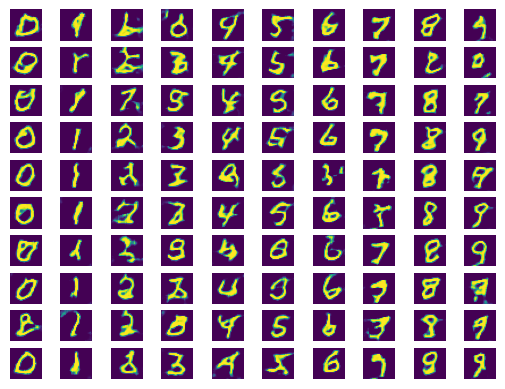

In [20]:
# load model
model = tf.keras.models.load_model('mnist_cGAN.h5', compile=False)


# generate points in latent space as input for the generator
latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)

import matplotlib.pyplot as plt
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

show_plot(X, 10)



